# PoE-VI Family

## Utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
from jax.scipy.linalg import solve_triangular
from jax.scipy.special import logsumexp

from functools import partial

from scipy.integrate import quad

import seaborn as sns
sns.set_theme(style="white")

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def logq_expert_precision(z, m, L):
    """
    Form the log expert (without the weight alpha)

    z: JAX array
    m: mean of the expert
    L: precision matrix of the expert
    """

    z_m = z - m
    return -1 * jnp.log(1 + z_m.T @ L @ z_m)



def grad_logq_precision(z, m, L):
    """
    Gradient of log expert. 
    """
    return -2 * jnp.exp(logq_expert_precision(z, m, L)) * L @ (z - m)



def Q_matrix_precision(z, m_all, L_all):
    """
    Compute the gradient of logq for a single z and batched m and S.

    z: D-dimensional vector
    m_all: K x D matrix (K sets of m vectors)
    L_all: K x D x D tensor (K sets of S matrices)

    Returns D x K matrix where each column is the gradient of logq evaluated at z for each set of m and S.
    """

    # Vectorize logq across the first axis of m_all and S_all
    logq_vmap = jax.vmap(grad_logq_precision, in_axes=(None, 0, 0))
    return logq_vmap(z, m_all, L_all).T


def logq_unnormalized_precision(z, alpha, m_all, L_all):
    """
    Batched version of logq over m_all and S_all using vmap.

    Args:
        z: D x 1 matrix.
        m_all: K x D matrix of means.
        S_all: K x D x D matrix of scale matrices.

    Returns:
        A K x 1 matrix of logq values.
    """
    # Evaluate log q_k(z)
    logqk = jax.vmap(logq_expert_precision, in_axes=(None, 0, 0))(z, m_all, L_all)

    return jnp.sum(logqk * alpha)


def density_batched(z_seq, alpha, m_all, S_all):
    """
    Batched version of the log density function using vmap.

    Args:
      z_seq: A sequence of input vectors.
      alpha: Weights for the experts.
      m_all: Means of the experts.
      S_all: Covariance matrices of the experts.

    Returns:
      A sequence of target values corresponding to each input vector in z_seq.
    """
    return jax.vmap(logq_unnormalized, in_axes=(0, None, None, None))(z_seq, alpha, m_all, S_all)




In [3]:
def compute_log_normalizing_constant_precision(
    key: jax.random.PRNGKey,
    m_all: jnp.ndarray,
    L_all: jnp.ndarray,
    alpha: jnp.ndarray,
    num_samples: int
) -> jnp.ndarray:
    
    """
    Monte Carlo estimate of the log normalizing constant of the product of t-experts. 

    Args:
        key: a JAX PRNGKey for reproducible Dirichlet sampling
        m_all: array of shape (K, D), component location vectors m_k
        L_all: array of shape (K, D, D), component precision matrices Λ_k
        alpha: array of shape (K,), Dirichlet concentration parameters α_k
        num_samples: Number of Monte Carlo draws from Dirichlet(alpha) to use in the estimate.

    Returns:
        logC_alpha_value: a scalar JAX array containing the Monte Carlo estimate of the log normalizing constant log C(α).
    """
    mus = m_all
    K, D = m_all.shape
    alpha0 = jnp.sum(alpha)
    # Degrees of freedom
    nu = 2.0 * alpha0 - D; nu = jnp.maximum(nu, 1e-6)

    safe_alpha = jnp.maximum(alpha, jnp.finfo(alpha.dtype).tiny)
    mu_quad = jnp.einsum('kd,kde,ke->k', m_all, L_all, m_all)

    key, subkey = jr.split(key)
    ws = jr.dirichlet(subkey, safe_alpha, shape=(num_samples,))

    def compute_params(key, w):
        # Compute Λ(w) + jitter: Λ(w) is the weighted sum of precision matrices
        Λ = jnp.tensordot(w, L_all, axes=1) + 1e-6 * jnp.eye(D)

        # location μ(w)
        b = jnp.einsum('k,kde,ke->d', w, L_all, m_all)
        m = jnp.linalg.solve(Λ, b)

        # compute γ(w) and scale factor
        γ = jnp.dot(w, mu_quad) - m @ Λ @ m
        γ = jnp.maximum(γ, 1e-12)
        
        return m, Λ, γ

    keys = jr.split(key, num_samples)
    # batched t-distribution parameters and offset
    ms, Λs, γs = jax.vmap(compute_params)(keys, ws)

    logdetS = lambda Λ, γ: D * jnp.log((1 + γ) / nu) - jnp.linalg.slogdet(Λ)[1]
    logdetS_value = jax.vmap(logdetS)(Λs, γs)

    logconst = (D/2) * jnp.log(jnp.pi) + jsp.special.gammaln(nu/2) - jsp.special.gammaln((nu+D)/2) + D/2 * jnp.log(nu)
    logC_alpha = logconst + 0.5*logdetS_value - alpha0 * jnp.log(1 + γs)
    
    logC_alpha_value = jsp.special.logsumexp(logC_alpha) - jnp.log(num_samples)
    return logC_alpha_value

def compute_normalizing_constant_precision(key, m_all, L_all, alpha, num_samples):
    logC_alpha = compute_log_normalizing_constant_precision(key, m_all, L_all, alpha, num_samples)
    return jnp.exp(logC_alpha)

In [4]:
@partial(jax.jit, static_argnames=('num_samples', 'clamp_scale'))
def sample_PoE_precision(
    key: jax.random.PRNGKey,
    alpha: jnp.ndarray,         # shape (K,)
    mus: jnp.ndarray,           # shape (K, D)
    Lambdas: jnp.ndarray,        # shape (K, D, D)
    num_samples: int = 1000,    # static for JIT
    jitter: float = 1e-6,
    clamp_scale: float = 5.0    # how many “σ” to allow
) -> tuple[jnp.ndarray, jnp.ndarray]:
    
    """
    Draw weighted samples from a product of t-experts.

    Args:
        key: JAX PRNGKey.
        alpha: Dirichlet concentrations, shape (K,).
        mus: Component means μ_k, shape (K, D).
        Lambdas: Component precisions Λ_k, shape (K, D, D).
        num_samples: number of samples (static for JIT).
        jitter: diagonal regularizer added to A for stability.
        clamp_scale: max allowed deviation from m in units of marginal σ.

    Returns:
        zs: samples array, shape (num_samples, D).
        weights: normalized importance weights, shape (num_samples,).
    """
    
    K, D = mus.shape
    sum_alpha = jnp.sum(alpha)
    nu = 2.0 * sum_alpha - D

    safe_alpha = jnp.maximum(alpha, jnp.finfo(alpha.dtype).tiny)
    Sigmas_inv = Lambdas 
    mu_quad = jnp.einsum('kd,kde,ke->k', mus, Sigmas_inv, mus)

    key, subkey = jr.split(key)
    ws = jr.dirichlet(subkey, safe_alpha, shape=(num_samples,))
    

    def single_sample(key, w):
        # build & jitter A_w
        A = jnp.tensordot(w, Sigmas_inv, axes=1)
        A += jitter * jnp.eye(D, dtype=A.dtype)

        # conditional mean m_w
        b = jnp.einsum('k,kde,ke->d', w, Sigmas_inv, mus)
        m = jnp.linalg.solve(A, b)

        # compute gamma and scale factor
        gamma = jnp.dot(w, mu_quad) - m @ A @ m
        one_plus = jnp.maximum(1.0 + gamma, 1e-12)
        safe_nu  = jnp.maximum(nu,      1e-6)

        # Cholesky for scale
        L = jnp.linalg.cholesky(A)
        L_inv = solve_triangular(L, jnp.eye(D, dtype=L.dtype), lower=True)
        scale = jnp.sqrt(one_plus / safe_nu)
        L_S = scale * L_inv

        # sample z
        key, kx, ku = jr.split(key, 3)
        x = jr.normal(kx, (D,))
        u = jr.chisquare(ku, safe_nu)
        z = m + (L_S @ x) * jnp.sqrt(safe_nu / jnp.maximum(u, 1e-12))

        # clip each coordinate so |z - m| <= clamp_scale * diag(L_S)
        dev = z - m
        max_dev = clamp_scale * jnp.diag(L_S)
        dev_clipped = jnp.clip(dev, -max_dev, max_dev)
        z = m + dev_clipped

        # compute the log weight
        log_det = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))
        lw = -0.5 * log_det - (safe_nu / 2.0) * jnp.log(one_plus)
        return z, lw

    keys = jr.split(key, num_samples)
    zs, lws = jax.vmap(single_sample)(keys, ws)

    lws_norm = lws - logsumexp(lws)

    
    return zs, jnp.exp(lws_norm)


## Example in 1D

In [5]:
K = 3
D = 1
# three experts
alpha = jnp.array([0.9, 1.1, 1.0])

# means
m_all = jnp.array([[0.0],
                 [3.0],
                 [-4.0]])

# precisions
S_all = jnp.stack([0.5*jnp.eye(D), 0.5 * jnp.eye(D), 0.5 * jnp.eye(D)])
L_all = jnp.linalg.inv(S_all)

In [6]:
# Compute via quadrature
f = lambda z: jnp.exp(logq_unnormalized_precision(z, alpha, m_all, L_all))
result, error = quad(f, -100, 100)

q_quad = lambda z: jnp.exp(logq_unnormalized_precision(z, alpha, m_all, L_all) - jnp.log(result))

In [7]:
# Normalizing constant
key = jr.PRNGKey(123)

logCalpha = compute_log_normalizing_constant_precision(key, m_all, L_all, alpha, 100_000)
q_mc = lambda z: jnp.exp(logq_unnormalized_precision(z, alpha, m_all, L_all) - logCalpha)

In [8]:
print(jnp.exp(logCalpha))

0.0042773625


In [9]:
print(result)

0.004310332288091199


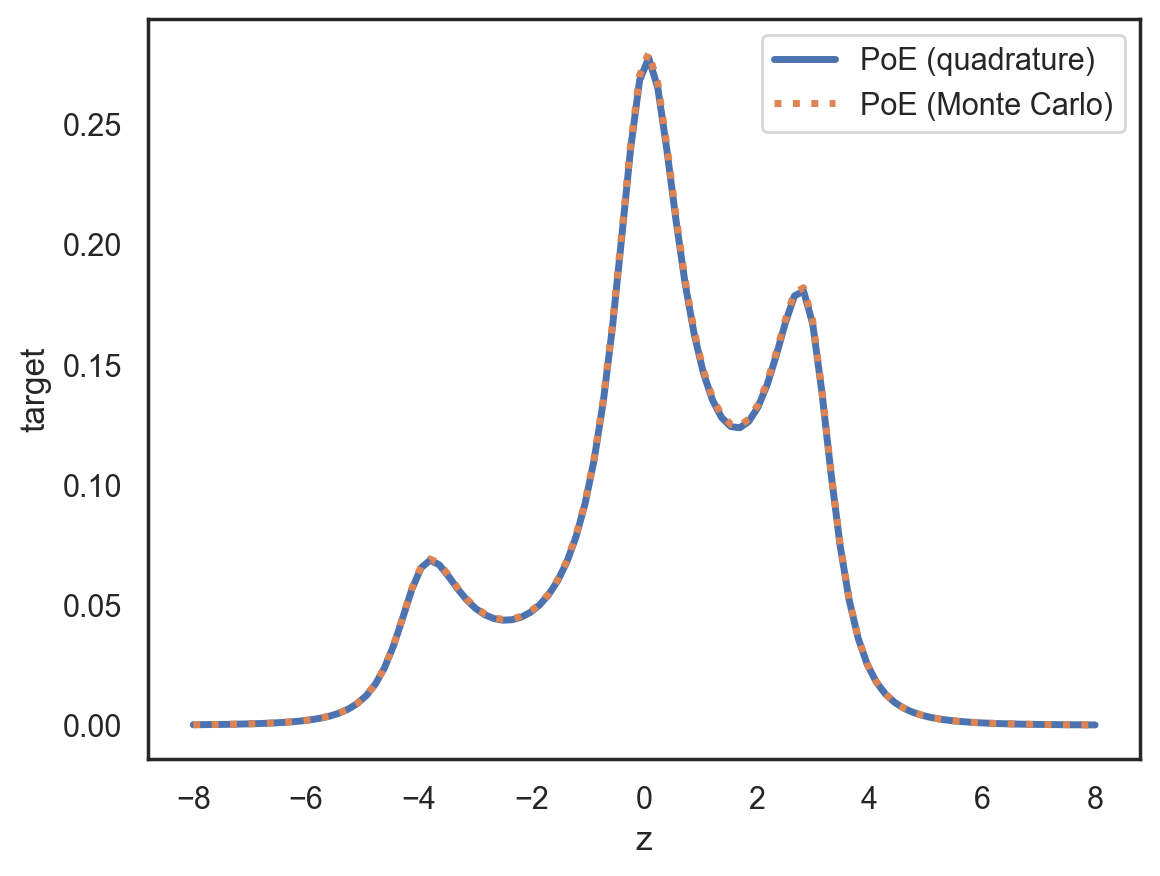

In [10]:
z_seq = jnp.linspace(-8, 8, 100).reshape(-1,1) 

plt.plot(z_seq, jax.vmap(q_quad)(z_seq), lw=2.5, label="PoE (quadrature)")
plt.plot(z_seq, jax.vmap(q_mc)(z_seq), lw=2.5, label="PoE (Monte Carlo)", ls="dotted")

plt.xlabel('z')
plt.ylabel('target')
plt.legend()

In [11]:
z_samples, weights = sample_PoE_precision(
    key, alpha, m_all, L_all, 10_000
)

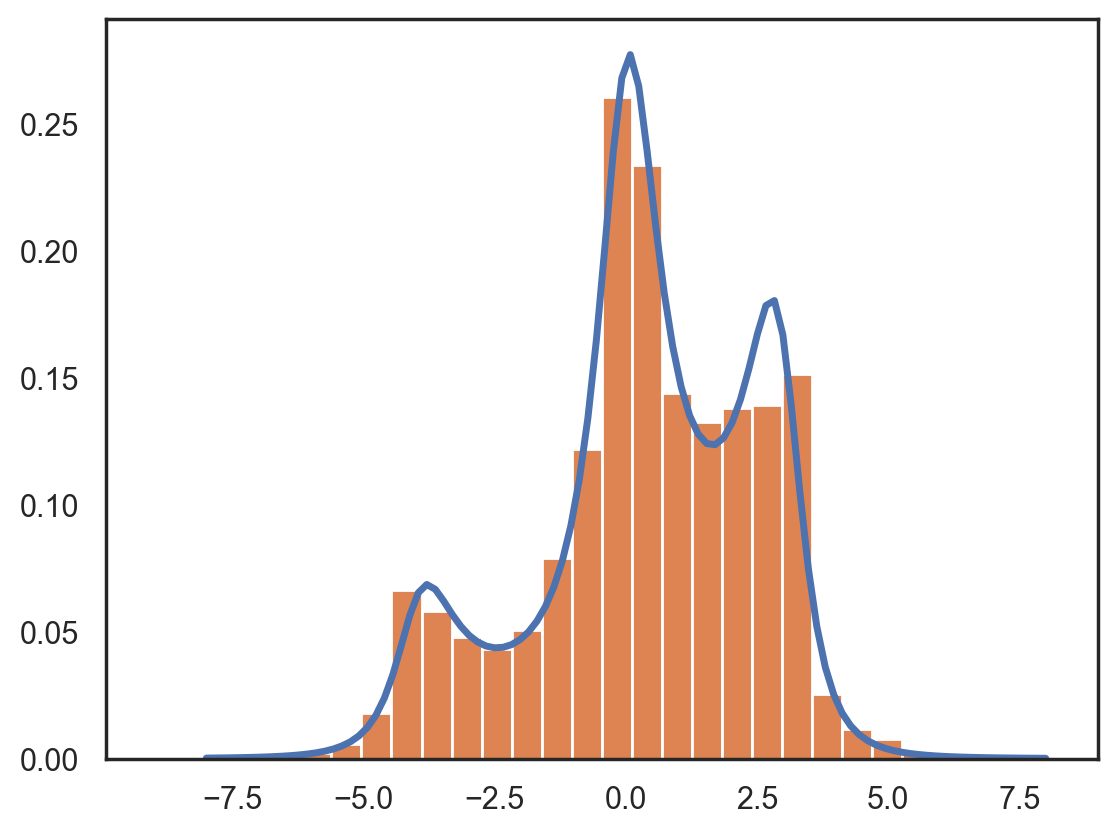

In [12]:
plt.plot(z_seq, jax.vmap(q_quad)(z_seq), lw=2.5)
plt.hist(z_samples.ravel(), bins=30, density=True, weights=weights);
